In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install pandas==0.22.0
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager_for_colab import DatasetManager
import BucketFactory

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support	

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#import lime
#import lime.lime_tabular
#from lime import submodular_pick;
import warnings
warnings.filterwarnings('ignore')

import joblib
import random

In [4]:
def train_with_unbalanced_data(X_train, X_test, feature_combiner, dataset_manager, current_args, scaler = None, iterations = 10):
  #index = np.arange(0, len(y_train), 1)
  #X_train = X_train.reindex(index)

  all_pipelines = []
  all_cls = []
  all_acc = []

  for i in range(iterations):

    #X_train_enc = feature_combiner.fit_transform(X_train, y_train)

    y_train = dataset_manager.get_label_numeric(X_train)
    #print(len(y_train))
    case_ids = dataset_manager.get_case_ids(X_train)
    #print(case_ids.shape)

    #Reduce to balanced dataset
    neg_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 0]
    pos_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 1]
    
    if len(neg_cases) > len(pos_cases):
      to_keep = random.sample(neg_cases, len(pos_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(pos_cases)])
    elif len(neg_cases) < len(pos_cases):
      to_keep = random.sample(neg_cases, len(pos_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(neg_cases)])

    y_train_resampled = dataset_manager.get_label_numeric(X_train_resampled)

    #Train model
    if cls_method == "rf":
      cls = RandomForestClassifier(n_estimators=500,
                                  max_features=current_args['max_features'],
                                  random_state=random_state)

    elif cls_method == "xgboost":
      cls = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=500,
                              learning_rate= current_args['learning_rate'],
                              subsample=current_args['subsample'],
                              max_depth=int(current_args['max_depth']),
                              colsample_bytree=current_args['colsample_bytree'],
                              min_child_weight=int(current_args['min_child_weight']),
                              seed=random_state)

    elif cls_method == "logit":
      cls = LogisticRegression(C=2**current_args['C'],
                              random_state=random_state)

    elif cls_method == "svm":
      cls = SVC(C=2**current_args['C'],
                gamma=2**current_args['gamma'],
                random_state=random_state)

    if cls_method == "svm" or cls_method == "logit":
      pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
    else:
      pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

    #print("fitting pipeline...")
    pipeline.fit(X_train_resampled, y_train_resampled)

    #Test Model
    test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
    y_test = [dataset_manager.get_label_numeric(group) for _,group in test_all_grouped]

    preds = pipeline.predict(X_test)
    #print(preds)
    acc = accuracy_score(y_test, preds)

    #save to list
    all_pipelines.append(pipeline)
    all_cls.append(cls)
    all_acc.append(acc)
  
  index = all_acc.index(max(all_acc))
    
  print("Accuracy Scores:", all_acc)
  print("Highest accuracy:", max(all_acc))
  print("Index:", index)

  pipeline = all_pipelines[index]
  cls = all_cls[index]

  return pipeline, cls

In [5]:
dataset_ref = "sepsis_cases"
params_dir = "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "index"
cls_method = "xgboost"
gap = 1
n_iter = 1
balanced_data = False

if bucket_method == "state":
    bucket_encoding = "last"
else:
    bucket_encoding = "agg"

method_name = "%s_%s"%(bucket_method, cls_encoding)

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1"]#, "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22

# create results directory
if not os.path.exists(os.path.join(params_dir)):
    os.makedirs(os.path.join(params_dir))
    
print(datasets)

['sepsis_cases_1']


In [6]:
for dataset_name in datasets:
    
    # load optimal params
    print("Setting up parameters...")
    optimal_params_filename = os.path.join(PATH, params_dir, "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))

    if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
        print("Parameters not found")
        
    with open(optimal_params_filename, "rb") as fin:
        args = pickle.load(fin)
        
    print(args)
    bucket_list=[5,10,15,20,25] #:)	
            
    # read the data
    print("setting up data...")
    dataset_manager = DatasetManager(dataset_name)
    data = dataset_manager.read_dataset()

    #data = dataset_manager.balance_data(data)
    #print('Case ID column', dataset_manager.case_id_col)
    cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

    # determine min and max (truncated) prefix lengths
    min_prefix_length = 1
    if "traffic_fines" in dataset_name:
        max_prefix_length = 10
    elif "bpic2017" in dataset_name:
        max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
    else:
        max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

    # split into training and test
    train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")
    
    if gap > 1:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
    else:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))
        
    start_test_prefix_generation = time.time()
    dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)
    test_prefix_generation_time = time.time() - start_test_prefix_generation
            
    offline_total_times = []
    online_event_times = []
    train_prefix_generation_times = []

    for ii in range(n_iter):
        # create prefix logs
        print("Creating logs...")
        start_train_prefix_generation = time.time()
        dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length, gap)
        train_prefix_generation_time = time.time() - start_train_prefix_generation
        train_prefix_generation_times.append(train_prefix_generation_time)
            
        # Bucketing prefixes based on control flow
        print("bucketing prefixes...")
        bucketer_args = {'encoding_method':bucket_encoding, 
                        'case_id_col':dataset_manager.case_id_col, 
                        'cat_cols':[dataset_manager.activity_col], 
                        'num_cols':[], 
                        'random_state':random_state}
        if bucket_method == "cluster":
            bucketer_args["n_clusters"] = int(args["n_clusters"])
        bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)

        start_offline_time_bucket = time.time()
        bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
        offline_time_bucket = time.time() - start_offline_time_bucket

        bucket_assignments_test = bucketer.predict(dt_test_prefixes)

        preds_all = []
        probas_all = []
        pred_types_all = []
        test_y_all = []
        nr_events_all = []
        offline_time_fit = 0
        current_online_event_times = []
        
        for bucket in set(bucket_assignments_test):
            print("Bucket" , bucket, "of", len(set(bucket_assignments_test)))
            print("sorting bucket...")
            #args has only one value - some error and so just using it
            #if bucket_method == "prefix":
            #    current_args = args[bucket]
            #else:
            current_args = args
            
            relevant_train_cases_bucket = dataset_manager.get_indexes(dt_train_prefixes)[bucket_assignments_train == bucket]
            relevant_test_cases_bucket = dataset_manager.get_indexes(dt_test_prefixes)[bucket_assignments_test == bucket]
            dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_test_cases_bucket)
            
            nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_bucket)))
            print('number events', len(nr_events_all))
            
            if len(relevant_train_cases_bucket) == 0:
                preds = [dataset_manager.get_class_ratio(train)] * len(relevant_test_cases_bucket)
                current_online_event_times.extend([0] * len(preds))
            
            else:
                dt_train_bucket = dataset_manager.get_relevant_data_by_indexes(dt_train_prefixes, relevant_train_cases_bucket) # one row per event
                train_y = dataset_manager.get_label_numeric(dt_train_bucket)
                test_y  = dataset_manager.get_label_numeric(dt_test_bucket)

                if len(set(train_y)) < 2:
                    preds = [train_y[0]] * len(relevant_test_cases_bucket)
                    current_online_event_times.extend([0] * len(preds))
                    test_y_all.extend(dataset_manager.get_label_numeric(dt_test_bucket))
                else:
                    print("choosing classifier...")
                    start_offline_time_fit = time.time()
                    feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])

                    if balanced_data==False:
                      pipeline, cls = train_with_unbalanced_data(dt_train_bucket, dt_test_bucket, feature_combiner, dataset_manager, current_args, iterations = 50)

                    else:
                      if cls_method == "rf":
                          cls = RandomForestClassifier(n_estimators=500,
                                                      max_features=current_args['max_features'],
                                                      random_state=random_state)

                      elif cls_method == "xgboost":
                          cls = xgb.XGBClassifier(objective='binary:logistic',
                                                  n_estimators=500,
                                                  learning_rate= current_args['learning_rate'],
                                                  subsample=current_args['subsample'],
                                                  max_depth=int(current_args['max_depth']),
                                                  colsample_bytree=current_args['colsample_bytree'],
                                                  min_child_weight=int(current_args['min_child_weight']),
                                                  seed=random_state)

                      elif cls_method == "logit":
                          cls = LogisticRegression(C=2**current_args['C'],
                                                  random_state=random_state)

                      elif cls_method == "svm":
                          cls = SVC(C=2**current_args['C'],
                                    gamma=2**current_args['gamma'],
                                    random_state=random_state)

                      if cls_method == "svm" or cls_method == "logit":
                          pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
                      else:
                          pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

                      print("fitting pipeline...")
                      pipeline.fit(dt_train_bucket, train_y)
                      
                      offline_time_fit += time.time() - start_offline_time_fit

            # predict separately for each prefix case
            preds = []
            probas = []
            pred_types = []
            
            test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
            print("test data shape", dt_test_bucket.shape)
            count_d=0 # count for deviant
            count_r=0 #count for regular

            tp_list = []
            tn_list = []
            fp_list = []
            fn_list = []

            iteration = 1
            
            for _, group in test_all_grouped:
                print ("Testing instance", iteration, 'of', len(test_all_grouped))
                test_y_group = dataset_manager.get_label_numeric(group)
                test_y_all.extend(test_y_group)
                    
                start = time.time()
                _ = bucketer.predict(group)
                
                if cls_method == "svm":
                    pred = pipeline.decision_function(group)
                else:
                  preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
                  pred = pipeline.predict(group)[0]
                  proba = pipeline.predict_proba(group)[:,preds_pos_label_idx]
                pipeline_pred_time = time.time() - start
                current_online_event_times.append(pipeline_pred_time / len(group))
                case_id = dataset_manager.get_case_ids(group)[0]
                
                if test_y_group == pred & pred == 0:
                  pred_type = 'TN'

                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = 1 - proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  tn_list.append(instance_dict)

                elif test_y_group == pred & pred == 1:
                  pred_type = 'TP'
                                    
                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  tp_list.append(instance_dict)

                elif test_y_group != pred & pred == 0:
                  pred_type = 'FN'
                  
                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = 1 - proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  fn_list.append(instance_dict)

                elif test_y_group != pred & pred == 1:
                  pred_type = 'FP'
                  
                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  fp_list.append(instance_dict)
                else:
                  print("ERROR: Prediction doesn't fit into any category. Check code.")
                      
                preds.append(pred)
                probas.extend(proba)
                pred_types.append(pred_type)
                iteration+=1
                
            preds_all.extend(preds)
            probas_all.extend(probas)
            pred_types_all.extend(pred_types)

            tn_path = os.path.join(PATH, "%s/%s_%s/instances/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            tp_path = os.path.join(PATH, "%s/%s_%s/instances/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            fn_path = os.path.join(PATH, "%s/%s_%s/instances/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            fp_path = os.path.join(PATH, "%s/%s_%s/instances/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            
            with open (tn_path, 'wb') as f:
              pickle.dump(tn_list, f)
            with open (tp_path, 'wb') as f:
              pickle.dump(tp_list, f)
            with open (fn_path, 'wb') as f:
              pickle.dump(fn_list, f)
            with open (fp_path, 'wb') as f:
              pickle.dump(fp_list, f)

            #Save models and encoders
            print('Saving models...')
            pipeline_path = os.path.join(PATH, "%s/%s_%s/pipelines/pipeline_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            bucketer_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/bucketer_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            joblib.dump(pipeline, pipeline_path)
            joblib.dump(feature_combiner, feat_comb_path)
            joblib.dump(cls, cls_path)
            joblib.dump(bucketer, bucketer_path)

            #Save training data
            print("saving data...")
            X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucket))
            Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucket))
            with open(X_train_path, 'wb') as f:
              pickle.dump(dt_train_bucket, f)
            with open(Y_train_path, 'wb') as f:
              pickle.dump(train_y, f)

            #Save testing data
            X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucket))
            Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucket))
            with open(X_test_path, 'wb') as f:
                pickle.dump(dt_test_bucket, f)
            with open(Y_test_path, 'wb') as f:
                pickle.dump(test_y_group, f)
      
        print("compiling results...")
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                print(dataset_name, method_name, cls_method, nr_events, "auc", np.nan)
            else:
                print(dataset_name, method_name, cls_method, nr_events, "auc", roc_auc_score(group.actual, group.predicted))
        print(dataset_name, method_name, cls_method, -1, -1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted))


Setting up parameters...
{'colsample_bytree': 0.6644726675241185, 'learning_rate': 2.8912123664890355, 'max_depth': 26, 'min_child_weight': 0, 'subsample': 0.9974573490603084}
setting up data...
Creating logs...
bucketing prefixes...
prefix
Bucket 1 of 29
sorting bucket...
number events 157
choosing classifier...
Accuracy Scores: [0.5159235668789809, 0.4394904458598726, 0.4585987261146497, 0.3630573248407643, 0.4267515923566879, 0.4394904458598726, 0.5095541401273885, 0.5095541401273885, 0.4267515923566879, 0.36942675159235666, 0.4585987261146497, 0.40764331210191085, 0.3375796178343949, 0.46496815286624205, 0.4012738853503185, 0.40764331210191085, 0.4713375796178344, 0.4267515923566879, 0.4394904458598726, 0.4585987261146497, 0.3503184713375796, 0.45222929936305734, 0.36942675159235666, 0.4585987261146497, 0.4140127388535032, 0.49044585987261147, 0.45222929936305734, 0.5987261146496815, 0.49044585987261147, 0.4140127388535032, 0.4585987261146497, 0.4713375796178344, 0.5159235668789809

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
accuracy_score(dt_results.actual, dt_results.predicted)

0.45808263136782995

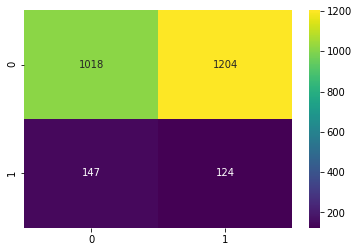

In [9]:
confusion = confusion_matrix(dt_results.actual, dt_results.predicted)
sns.heatmap(confusion, annot=True, fmt = 'd', cmap='viridis')#, categories = ['Negative', 'Positive'])